In [1]:
%matplotlib inline

In [2]:
import gym
import matplotlib.pyplot as plt
import pickle            as pkl
import torch
import torch.nn          as nn
from torch.autograd import Variable
import torchvision.transforms as T
from itertools import count
from collections import namedtuple
import random
from time import sleep
import numpy as np
from copy import deepcopy
from IPython import display

In [3]:
env = gym.make('BreakoutDeterministic-v4')
screen_sample = env.reset()

In [ ]:
env.action_space.n

In [ ]:
env.unwrapped.get_action_meanings()

In [4]:
def recompile_obs(obs):
    obs = obs[25:193:2, ::2]
    obs = np.mean(obs, axis=2).astype(np.uint8)
    return obs

In [5]:
recompiled_sample = recompile_obs(screen_sample)
print(recompiled_sample.shape)

(84, 80)


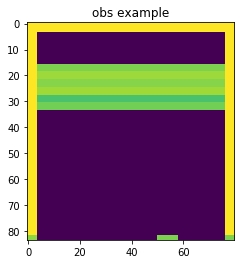

In [6]:
plt.figure()
plt.imshow(recompiled_sample)
plt.title('obs example')
plt.show()

In [7]:
def transform_reward(reward):
    return int(np.sign(reward))

In [8]:
class DQN(nn.Module): 
    def __init__(self):
        super(DQN, self).__init__()
        self.cnn = nn.Sequential(
            # 84x80 | 4 -> 20x20 | 16 
            nn.Conv2d(4, 16, kernel_size=8, stride=4, padding=(0, 2)),
            nn.ReLU(inplace=True),
            # 20x20 | 16 -> 9x9 | 32
            nn.Conv2d(16, 32, kernel_size=4, stride=2),
        )

        self.sel = nn.Sequential(
            nn.Linear(9 * 9 * 32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size(0), -1)
        out = self.sel(out)
        return out

In [ ]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Положить переход в память."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """ Получить сэмпл из памяти """
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [9]:
Hyperparams = {
    'BATCH_SIZE' : 32,
    'MEMORY_SIZE': 750000,
    'MEM_MIN'    : 100000,
    'BACKUP_FREQ': 10000,
    'DISCOUNT'   : 0.99,
    'LR'         : 0.00025,
    'MOMENTUM'   : 0.95,
    'E_START'    : 1.,
    'E_MIN'      : 0.1,
    'E_EXP'      : 1000000,
    'EPOCHS'     : 150, 
    'EPOCH_SIZE' : 50000,
    'MAX_NOPS'   : 30
}

In [10]:
def get_eps_treshold(step):
    return max(Hyperparams['E_MIN'], Hyperparams['E_START'] + \
                       ((Hyperparams['E_MIN'] -  Hyperparams['E_START'])/Hyperparams['E_EXP']) * step)

In [ ]:
memory    = ReplayMemory(Hyperparams['MEMORY_SIZE'])
model     = DQN().cuda()
backup    = deepcopy(model)
optimizer = torch.optim.RMSprop(params=model.parameters(), lr=Hyperparams['LR'], momentum=Hyperparams['MOMENTUM'])
print(model)

In [11]:
def get_state(action):
    reward, done = 0, False
    state = np.zeros(shape=(4, 84, 80)).astype(np.uint8)
    for i in range(4):
        obs, t_rew, t_done, _ = env.step(action)
        reward += t_rew
        done = done or t_done
        if done:
            return None, reward, done
        else:
            state[i] = recompile_obs(obs)
    return state, reward, done

In [ ]:
sample_state, _, _ = get_state(0)
sample_state.shape

In [12]:
def state_to_tensor(state):
    tensor = torch.from_numpy(state / 255.).type(torch.cuda.FloatTensor).unsqueeze(0).cuda()
    return tensor

In [ ]:
sample_tensor = state_to_tensor(sample_state)
sample_tensor

In [ ]:
sample_action = model(Variable(sample_tensor, volatile=True)).data.max(1)[1][0]
sample_action

In [13]:
def choose_action(step, tensor):
    sample = random.random()
    if sample > get_eps_treshold(step):
        return model(Variable(tensor, volatile=True)).data.max(1)[1][0]
    else:
        return random.randrange(4)

In [ ]:
choose_action(1, sample_tensor)

In [ ]:
from torch.autograd import Variable

def optimize_model():
    transitions = memory.sample(Hyperparams['BATCH_SIZE'])
    
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.cuda.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))

    
    # Блокируем прохождение градиента для вычисления функции ценности действия
    # volatile=True
    non_final_next_states = Variable(torch.cat([state_to_tensor(s) for s in batch.next_state
                                                if s is not None]), volatile=True)
    
    state_batch = Variable(torch.cat([state_to_tensor(s) for s in batch.state]))
    action_batch = Variable(torch.cat([torch.cuda.LongTensor([[a]]) for a in batch.action]))
    reward_batch = Variable(torch.cat([torch.cuda.FloatTensor([r]) for r in batch.reward]))
    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колоки, которые соответствуют нашим действиям на щаге
    
    state_action_values = model(state_batch).gather(1, action_batch)
    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = Variable(torch.zeros(Hyperparams['BATCH_SIZE']).type(torch.cuda.FloatTensor))
    next_state_values[non_final_mask] = backup(non_final_next_states).max(1)[0] # берем значение максимума
    # Для подсчета лоса нам нужно будет разрешить прохождение градиента по переменной
    # блокировку, которого мы унаследовали
    # requires_grad=False
    next_state_values.volatile = False
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * Hyperparams['DISCOUNT']) + reward_batch
    # Считаем ошибку Huber loss
    loss = torch.nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values)

    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in model.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [ ]:
def show_state():
    plt.grid(True)
    plt.plot(epoch_rewards)
    plt.title('Epoch {0:3d}, avg reward {1:.2f}'.format(epoch, ep_rew))
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
epoch = 0
steps_done = 0

episode_rewards = []
epoch_rewards = []

In [ ]:
while epoch < Hyperparams['EPOCHS']:
   
    env.reset()

    first_action = env.action_space.sample()

    state, _, _ = get_state(first_action)

    total_reward = 0
    nops = 0
    for t in count():

        action = choose_action(steps_done, state_to_tensor(state))

        if action == 0:
            nops += 1
            if nops >= Hyperparams['MAX_NOPS']:
                action = 1 + random.randrange(2)
                nops = 0
        else:
            nops = 0

        next_state, reward, done = get_state(action)

        memory.push(state, action, next_state, transform_reward(reward))

        state = next_state

        total_reward += reward

        steps_done += 1
        if steps_done % Hyperparams['EPOCH_SIZE'] == 0:

            epoch += 1

            ep_rew = sum(episode_rewards)/len(episode_rewards)
            episode_rewards = []
            epoch_rewards.append(ep_rew)

            with open('dqn_checkpoint.pkl', 'wb') as f:
                pkl.dump(model, f)

            show_state()

        if steps_done % Hyperparams['BACKUP_FREQ'] == 0:
            backup = deepcopy(model)

        if len(memory) > Hyperparams['MEM_MIN']:
            optimize_model()

        if done:
            episode_rewards.append(total_reward)
            break
    

print('Complete')

In [ ]:
with open('dqn_final.pkl', 'wb') as f:
    pkl.dump(model, f)

In [ ]:
print('Yay?')

In [16]:
with open('dqn_final.pkl', 'rb') as f:
    model = pkl.load(f)
    model.cuda()

EOFError: Ran out of input